<a href="https://colab.research.google.com/github/gabselbach/TCC-implementacoes/blob/master/An%C3%A1lise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
import re
import sys
import pandas as pd
from nltk.tokenize import word_tokenize
!pip install python-Levenshtein
from Levenshtein import distance
from openpyxl import load_workbook
import re
from re import match as re_match
from re import compile as re_compile
from google.colab import files
from unicodedata import normalize
import spacy
import spacy.cli
import ast
spacy.cli.download('pt_core_news_sm')
nlp = spacy.load("pt_core_news_sm")

# Função para filtrar correções falta de acento uol


In [ ]:
def PegaCorrecao2(txt):
  palavras=[]
  p1 =''
  p2=''
  PalavrasEscritas = re.findall(r'<strong>(.*?)</strong>(.*?)<span style=\"color:#00b050\">(.*?)</span>',txt)
  r = PalavrasEscritas.copy()
  novo = []
  val =[]
  v=0
  acento = re.compile('à|[á-ú]|ê|ô|ã|õ|í') 
  outro = re.compile("[,|:|?]")
  espaço = re.compile("^[[a-z]+\s.]$")
  for palavra in r:
    p1 = re.sub(' ','',palavra[0])
    p2 = re.sub(' ','',palavra[2])
    conteudo = nlp(palavra[0])
    valores1 = conteudo.text.split()
    conteudo = nlp(palavra[2])
    valores2 = conteudo.text.split()
    if(len(valores1)==len(valores2)):
      i=0
      for x in valores2:
        if(distance(x,valores1[i])==1 and (acento.search(str(x))) and (not acento.search(str(valores1[i]))) ):
          norm = normalize('NFKD',str(x)).encode('ASCII', 'ignore').decode('ASCII').lower()
          palavras.append(str(x))   
        i=i+1
  return palavras

# Criando o dataset das correções acentuais do UOL

In [ ]:
UOL = pd.read_csv('TodasReds.csv')
SetUol=[]
SetUol2=[]
palavrasCorrigidasUOL=[]
def isdigit(s):
    comp = re_compile("^\d+?\.\d+?$")
    if comp.match(s) is None:
        return s.isdigit()
    return True
for (i,row) in UOL.iterrows():
  if(i<101):
    qtd=0
    red = row['textoTotal']
    redSotexto = row['textoSemTag']
    manual = []
    manual =PegaCorrecao2(red)
    conteudo = nlp(redSotexto)
    palavras = conteudo.text.split()
    copytexto = palavras.copy()
    palavrasComuns = {'publica','atração','acontece','antigas','pertence','pais','muita','econômico','sofre','ideia','coloca','mídia','para','correta','pública','integra','julga','justifica','mais','pela','fica','favorece','reforça','larga','esta','significa','disse','corte','começa','espera','merece','parece','formas','esquece'	}
    for x in copytexto:
      if(len(x) < 2 or (x in palavrasComuns)):
        palavras.remove(x)
    Novo = []
    l=0
    for j in palavras:
      
      pnorm = normalize('NFKD',str(j)).encode('ASCII', 'ignore').decode('ASCII').lower()
      temp={
        'correc': 0,
        'palavra': j
      }
      copymanual = manual.copy();
      Novo.append(temp)
      for k in copymanual:
        pNormManual = normalize('NFKD',str(k)).encode('ASCII', 'ignore').decode('ASCII').lower()
        if(pnorm == pNormManual and distance(str(j),str(k))==1 and len(str(j))>2):
          Novo[l]["correc"]=1
          if(str(j)=="vem"):
            print(i)
          palavrasCorrigidasUOL.append(Novo[l]['palavra'])
          qtd +=1
          manual.remove(k)
          break
      l +=1
    Novo = pd.DataFrame(Novo)
    temp2 = {
      'texto': redSotexto,
      'palavrasCorrec': Novo.copy(),
      'qtd':qtd
    }
    SetUol2.append(temp2)
  else:
    break
SetUol2 = pd.DataFrame(SetUol2)
SetUol2.to_excel('setCorrecUol.xlsx', sheet_name='analiseRedações')
files.download('setCorrecUol.xlsx')


# Comparação das correções do Uol e do Acentua Fácil para obter os resultados, já calculando os vetores de real e predito

In [ ]:
acentua = pd.read_excel('DICIO.xlsx')
pd.set_option('display.max_rows', 3000)
pd.set_option('display.max_columns', 20)
pd.set_option('display.width', 3000000)
red = []
textosU = SetUol2['texto'] #texto normal
palavrasU = SetUol2['palavrasCorrec'] 
m=0
acento = re.compile('à|[á-ú]|ê|ô|ã|õ|í')
real=[]
predito=[]
TP=0
FP=0
TN=0
FN=0
correcs=[]
total=0
redacoes=[]
u=0
DicioTudo=[]
VopTP=[]
palavrasCorrigidasErradas=[]
palavrasNaoCorrigidas=[]
pCorr=[]
for (l,row) in acentua.iterrows(): 
  textoA =normalize('NFKD',row["texto"]).encode('ASCII', 'ignore').decode('ASCII').lower()
  redAP = row["totalPalavras"]
  redUolP = pd.DataFrame(palavrasU[l].copy())
  redAP = ast.literal_eval(redAP)
  redAP = pd.DataFrame(redAP)
  j=0
  uolC=0
  AcentuaC=0
  y=0
  for (j,row2) in redAP.iterrows():
    total+=1
    palavra = redUolP.loc[j,"palavra"]
    tok =normalize('NFKD',redUolP.loc[j,"palavra"]).encode('ASCII', 'ignore').decode('ASCII').lower()
    correc1 = redUolP.loc[j,"correc"]
    tok2 =normalize('NFKD',row2["palavra"]).encode('ASCII', 'ignore').decode('ASCII').lower()
    correc2 = row2["correc"]
    real.append(correc1)
    predito.append(correc2)
    if(tok==tok2):
        if(correc1==1 and correc2==1):
          TP +=1
        elif(correc1==0 and correc2==1):
          FP +=1
        elif(correc1==0 and correc2==0):
          TN +=1
        elif(correc1==1 and correc2==0):
          DicioTudo.append(redUolP.loc[j,"palavra"])
          FN +=1
  redacoes.append(t) 
redacoes=pd.DataFrame(redacoes)
print('valor de TP:',TP,'\n')
print('valor de FP:',FP,'\n')
print('valor de TN:',TN,'\n')
print('valor de FN:',FN,'\n')
print('qtd palavras',total) 

# gerando matriz de confusão

In [ ]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(real, predito)
import seaborn as sns
sns.heatmap(cf_matrix, annot=True, cmap='Blues')

# gerando métricas de análise

In [ ]:
from sklearn.metrics import classification_report
target_names = ['sem correção', 'com correção']
print(classification_report(real, predito))

# gráfico de barras da distruição das notas da competência 1 do  ENEM

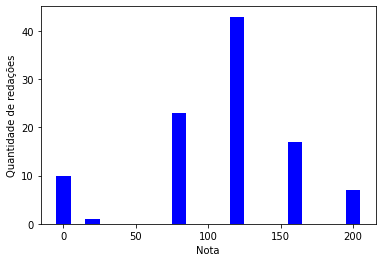

In [3]:
import numpy as np
import matplotlib.pyplot as plt
valor = np.array([0,20,80,120,160,200])	
freq = np.array([10,1,23,43,17,7])
plt.ylabel('Quantidade de redações')
plt.xlabel('Nota')
plt.bar(valor, freq,width=10, color="b")
plt.show()